In [1]:
import os
os.chdir(os.getcwd().replace('/Code', ''))

In [2]:
import pandas as pd
import gzip
import pickle as pkl
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

from sklearn import decomposition, preprocessing
import seaborn as sns
from sklearn.manifold import TSNE

In [3]:
with gzip.open('Matrices/CVs_FINALE.pkl.gz', 'rb') as f:
        CVs = pkl.load(f)
CVs.shape

(8086, 3)

In [4]:
joincv = [" ".join(CVs.loc[cv]['vocab_cv_list']) for cv in CVs.index]

## Matrice d'occurrences

In [20]:
vectorizer = CountVectorizer(token_pattern="[\S]+", min_df=30)
X = vectorizer.fit_transform(joincv)
DataFrame_Count_reduite = pd.DataFrame(X.toarray(),  columns=vectorizer.get_feature_names(), index=CVs.index)
print("Le vocabulaire retenu contient", DataFrame_Count_reduite.shape[1], "tokens pour", DataFrame_Count_reduite.shape[0], 'cv.')

Le vocabulaire retenu contient 6164 tokens pour 8086 cv.


## Matrice TFIDF

In [8]:
vectorizer = TfidfVectorizer(token_pattern="[\S]+", min_df=10)
X = vectorizer.fit_transform(joincv)
DataFrame_TFIDF_reduite = pd.DataFrame(X.toarray(),  columns=vectorizer.get_feature_names(), index=CVs.index)
print(DataFrame_TFIDF_reduite.shape)

(8086, 12042)


## Matrice de dissimilarité 

In [9]:
matrice_dissimilarity_reduite = 1-cosine_similarity(DataFrame_TFIDF_reduite)
print(matrice_dissimilarity_reduite.shape)

(8086, 8086)


# Représentation vectorielle des CV

In [10]:
def representation_acp_tsne(matrice,clusters = None, color=None, nb_axes=50, seed=123):# Calcul des composantes principales
    pca = decomposition.PCA(n_components = nb_axes, random_state=seed)
    pca.fit(matrice)
    print('Cumulative variance explained by', nb_axes,' principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))
    #critere du coude
    plt.figure(figsize=(15, 5))
    #plt.subplot(2,4,1)
    plt.bar(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_)
    plt.show()
    # projection des individus/CV
    X_projected = pca.transform(matrice)
    
    if clusters.all()!=None:
        uniq_classes = np.unique(clusters)
        if color!=None and len(color)>=len(uniq_classes):
            clusters_col = [color[i] for i in clusters]
    

    plt.figure(figsize=(15, 10))
    plt.subplot(2,3,1)
    plt.scatter(x=X_projected[:, 0], y=X_projected[:, 1], alpha=0.5, c=clusters_col)
    plt.xlabel("axe 0")
    plt.ylabel("axe 1")
    plt.subplot(2,3,2)
    plt.scatter(x=X_projected[:, 0], y=X_projected[:, 2], alpha=0.5, c=clusters_col)
    plt.xlabel("axe 0")
    plt.ylabel("axe 2")
    plt.subplot(2,3,3)
    plt.scatter(x=X_projected[:, 1], y=X_projected[:, 2], alpha=0.5, c=clusters_col)
    plt.xlabel("axe 1")
    plt.ylabel("axe 2")
    plt.subplot(2,3,4)
    plt.scatter(x=X_projected[:, 0], y=X_projected[:, 3], alpha=0.5, c=clusters_col)
    plt.xlabel("axe 0")
    plt.ylabel("axe 3")
    plt.subplot(2,3,5)
    plt.scatter(x=X_projected[:, 1], y=X_projected[:, 3], alpha=0.5, c=clusters_col)
    plt.xlabel("axe 1")
    plt.ylabel("axe 3")
    plt.subplot(2,3,6)
    plt.scatter(x=X_projected[:, 2], y=X_projected[:, 3], alpha=0.5, c=clusters_col)
    plt.xlabel("axe 2")
    plt.ylabel("axe 3")
    plt.show()

    Y = TSNE(random_state=seed).fit_transform(X_projected)

    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(x=Y[:, 0], y=Y[:, 1], alpha=0.5, c=clusters_col)
    plt.title("ACP + TSNE")
    plt.legend(*scatter.legend_elements(),
                     title="Classes",loc='center left', bbox_to_anchor=(1, 0.5))
    if clusters.all()!=None:
        
        for c in uniq_classes:
            cvs_id = [i for i in range(len(clusters)) if clusters[i]==c]
            xtext, ytext = np.median(Y[cvs_id, :], axis=0)
            plt.text(xtext, ytext, str(c), fontsize=24)
    plt.show()
    return X_projected, Y

# CAH

In [11]:
%%time
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(matrice_dissimilarity_reduite)

CPU times: user 3min 17s, sys: 112 ms, total: 3min 17s
Wall time: 3min 17s


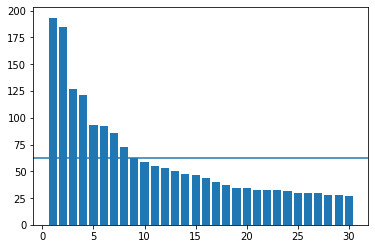

62.710282816472294


In [12]:
last = linkage_matrix[-30:, 2]
last_reverse = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.bar(idxs, last_reverse)
plt.axhline(y=last_reverse[8])
plt.show()
print(last_reverse[8])

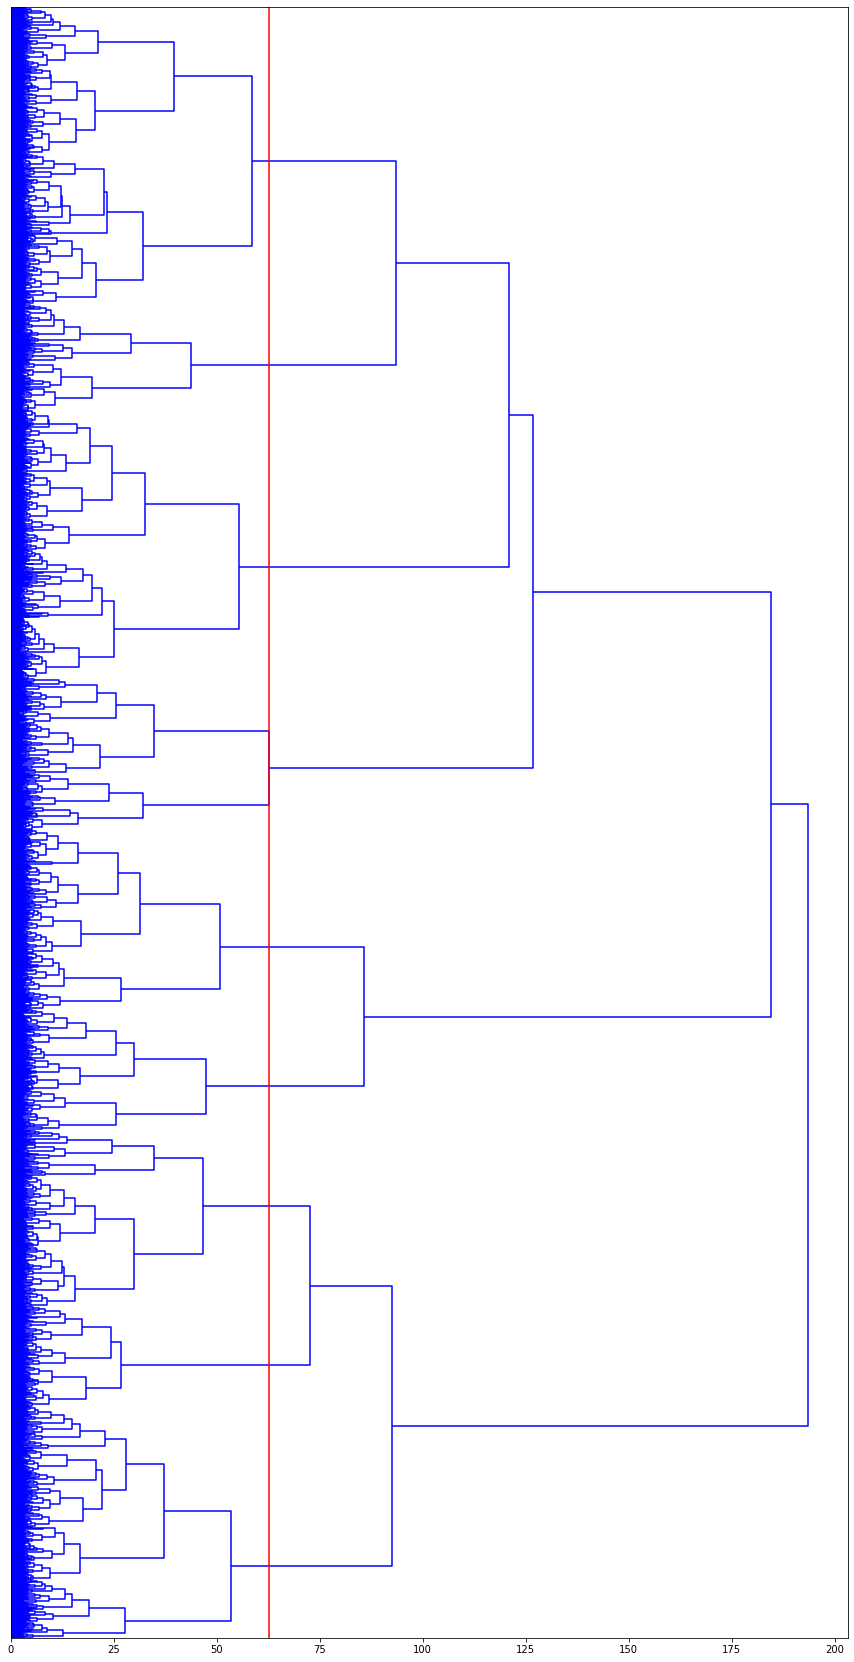

In [13]:
fig, ax = plt.subplots(figsize=(15, 30))
ax = dendrogram(linkage_matrix, orientation="right", no_labels=True, color_threshold=0)
plt.axvline(x=last_reverse[8], c='red')
plt.show()

In [14]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(linkage_matrix,t=last_reverse[8],criterion='distance')

In [15]:
from collections import Counter
nb_classes = len(Counter(clusters).keys())
print(Counter(clusters).keys())

dict_keys([8, 2, 6, 5, 3, 9, 1, 7, 4])


### Application

In [16]:
color = ['#e6194B', '#f58231', '#ffe119', '#bfef45', "#3cb44b", "#42d4f4", "#4363d8", "#911eb4", "#f032e6", "#a9a9a9", "pink","yellow",'blue','green', 'black','grey',"#454455", "#787878"]

Cumulative variance explained by 50  principal components: 0.20375983588137198


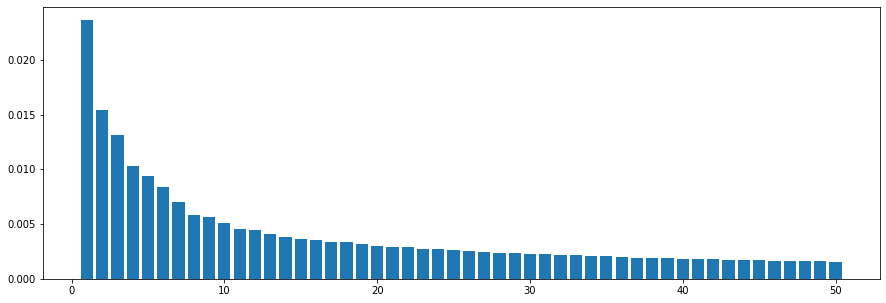

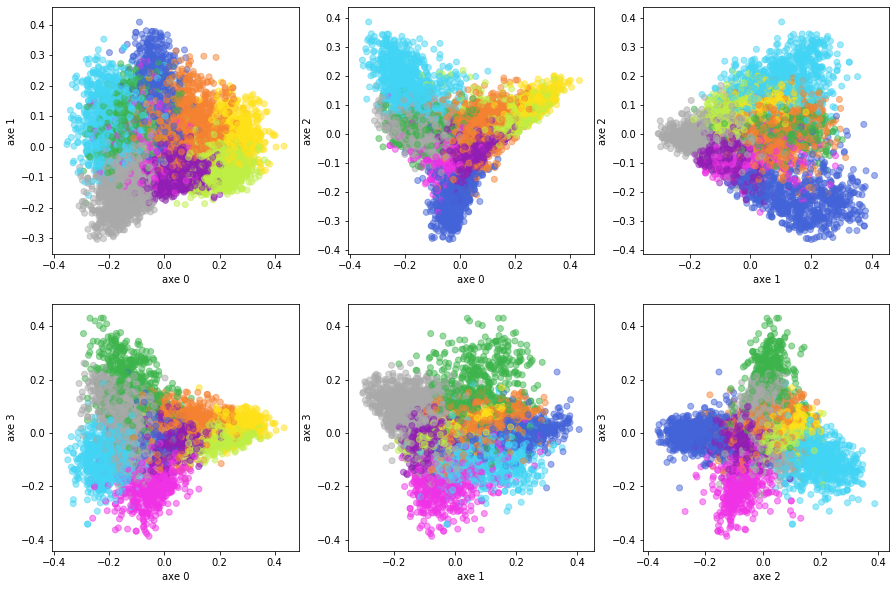

/home/id1019/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


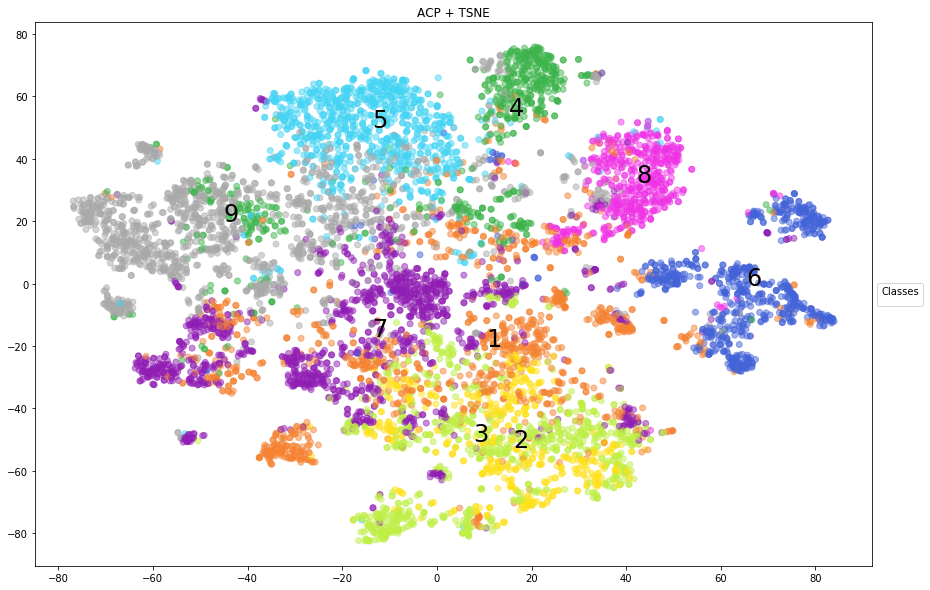

(array([[-0.0165062 , -0.08630648, -0.04458168, ...,  0.04203821,
         -0.01436331,  0.01349295],
        [ 0.34373275,  0.15019044,  0.18979954, ..., -0.06928893,
          0.00791354,  0.02445465],
        [-0.01304591,  0.14719167, -0.28910417, ...,  0.06450685,
         -0.05087354, -0.02294302],
        ...,
        [-0.11004985,  0.00074775, -0.00826009, ..., -0.07428303,
         -0.03206576, -0.014128  ],
        [ 0.07016213,  0.11561838,  0.04863651, ...,  0.02529806,
          0.01182783,  0.0371639 ],
        [-0.08697716, -0.11907856, -0.07841751, ...,  0.00192459,
          0.00853709,  0.00460588]]),
 array([[ 39.549557  ,  21.263063  ],
        [ 30.72802   , -58.246838  ],
        [ 69.11384   ,  -0.19966549],
        ...,
        [  8.934776  ,  38.519226  ],
        [-34.620968  , -54.545795  ],
        [ 39.90815   ,  39.434834  ]], dtype=float32))

In [17]:
representation_acp_tsne(DataFrame_TFIDF_reduite,clusters,color)

In [18]:
from collections import Counter
def top_mots_classes(matrice, clusters, top=10):
    print("Top mots dans les cv:")
    nom_col = ['classe','nb_CV']
    nom_col.extend(["term"+ str(j+1) for j in range(top)])
    
    classes = np.sort(list(Counter(clusters).keys()))
    
    
    result = []
    for c in classes:
        id_CVs_c = [matrice.index[i] for i in range(len(clusters)) if clusters[i]==c]
        result_c = [c, len(id_CVs_c)] 
        
        sub_df_count_c = matrice.loc[id_CVs_c]
        result_c.extend(list(sub_df_count_c.sum(axis=0).sort_values(ascending=False).head(top).index))
        result.append(result_c)
    resume_cluster = pd.DataFrame(result, columns= nom_col)
    return resume_cluster

In [19]:
top_mots_classes(DataFrame_Count_reduite, clusters, top=15)

Top mots dans les cv:


,classe,nb_CV,term1,term2,term3,term4,term5,term6,term7,term8,term9,term10,term11,term12,term13,term14,term15
0,1,1147,test,functional,manager,support,environment,customer,tool,sql,service,user,process,new,specification,software,design
1,2,496,risk,functional,office,accounting,market,financial,test,manager,tool,support,process,specification,new,user,monitoring
2,3,874,risk,financial,office,analyst,calypso,market,finance,manager,bank,customer,product,support,accounting,credit,control
3,4,600,net,sql,c,server,environment,design,web,asp,developer,tool,visual,windows,software,service,studio
4,5,893,java,spring,design,j2ee,web,environment,sql,service,server,developer,hibernate,eclipse,engineer,test,tool
5,6,744,server,environment,production,windows,administration,sql,database,network,support,linux,unix,installation,engineer,migration,backup
6,7,1334,manager,customer,support,service,new,production,master,university,consultant,computer,school,engineer,office,design,product
7,8,528,data,datum,big,sql,design,environment,hadoop,r,java,spark,python,tool,server,architecture,machine
8,9,1470,web,developer,php,design,javascript,java,mysql,technology,jquery,css,html,js,computer,environment,integration


Résultats non satisfaisant